In [1]:
!pip install autoimpute

     ---------------------------------------- 98.1/98.1 kB 2.8 MB/s eta 0:00:00
     ------------------------------------- 501.9/501.9 kB 15.4 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 51.7 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 9.4 MB/s eta 0:00:00
     ---------------------------------------- 242.4/242.4 kB ? eta 0:00:00
     --------------------------------------- 12.9/12.9 MB 40.9 MB/s eta 0:00:00
  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
     ---------------------------------------- 50.1/50.1 kB ? eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 39.4 MB/s eta 0:00:00
     ---------------------------------------- 41.3/41.3 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): st

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.14.dev0 requires pyre-extensions==0.0.23, which is not installed.
ydata-profiling 4.12.1 requires matplotlib<3.10,>=3.5, but you have matplotlib 3.10.0 which is incompatible.
tensorflow 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
sktime 0.26.0 requires pandas<2.2.0,>=1.1, but you have pandas 2.2.3 which is incompatible.
pycaret 3.3.2 requires matplotlib<3.8.0, but you have matplotlib 3.10.0 which is incompatible.
pycaret 3.3.2 requires pandas<2.2.0, but you have pandas 2.2.3 which is incompatible.
onnx 1.14.1 requires protobuf>=3.20.2, but you have protobuf 3.20.0 which is incompatible.

[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] 

In [11]:
!pip install duckdb ydata-profiling pycaret  xgboost lightgbm catboost

^C


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import duckdb
import plotnine as p9

import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from kmodes.kmodes import KModes

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from kmodes.kprototypes import KPrototypes
from sklearn.metrics import adjusted_rand_score


In [4]:
full_train_csv_data = pd.read_csv("../playground-series-s4e12/train.csv")
full_test_csv_data = pd.read_csv("../playground-series-s4e12/test.csv")

<Axes: ylabel='Frequency'>

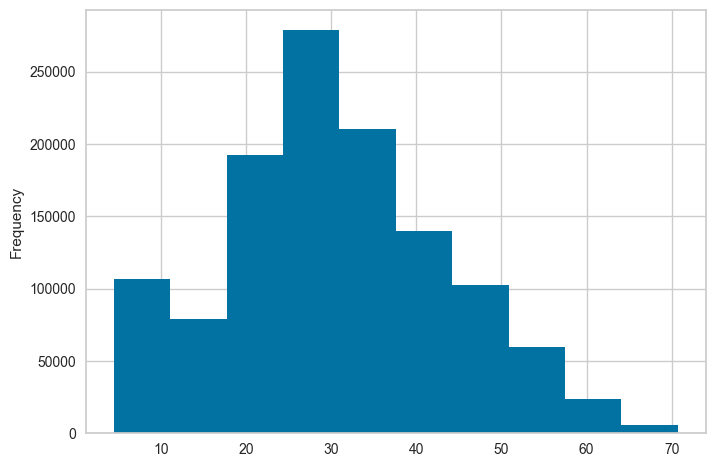

In [91]:
np.sqrt(full_train_csv_data["Premium Amount"]).plot.hist()

<Axes: ylabel='Frequency'>

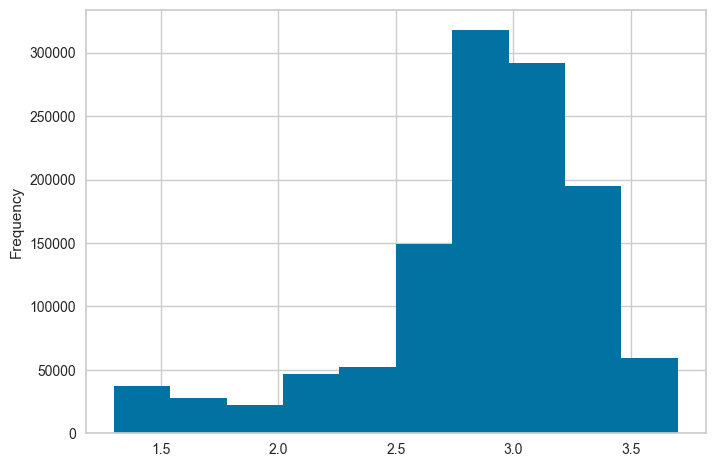

In [92]:
np.log10(full_train_csv_data["Premium Amount"]).plot.hist()


In [5]:
len(full_test_csv_data)

800000

In [6]:
len(full_train_csv_data)

1200000

In [7]:
import pandas as pd
from pycaret.regression import setup, compare_models, add_metric

In [8]:
# Separate numeric and categorical columns
numeric_cols = full_test_csv_data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = full_test_csv_data.select_dtypes(include=['object']).columns

In [9]:
from missforest import MissForest


In [8]:
categorical_cols

Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Policy Start Date', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type'],
      dtype='object')

In [2]:
from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [97]:
def treat_dataset_pandas_init(dataset):
    dataset = dataset.copy()
    dataset['Policy Start Date'] = pd.to_datetime(dataset['Policy Start Date'])
    # Get the last date in the dataset
    last_date = dataset['Policy Start Date'].max()
    
    # Add 1 day to the last date
    reference_date = last_date + pd.Timedelta(days=1)
    
    # Calculate Customer Tenure in years from the reference date
    dataset['Customer Tenure'] = (reference_date - dataset['Policy Start Date']).dt.days / 365
    dataset['Claim Frequency'] = dataset['Previous Claims'] / dataset['Insurance Duration']
    # Extract year, month, day, hour, minute, second from 'Policy Start Date'
    dataset['Policy Start Year'] = dataset['Policy Start Date'].dt.year
    dataset['Policy Start Month'] = dataset['Policy Start Date'].dt.month
    dataset['Policy Start Day'] = dataset['Policy Start Date'].dt.day
    dataset['Policy Start Hour'] = dataset['Policy Start Date'].dt.hour
    dataset['Policy Start Minute'] = dataset['Policy Start Date'].dt.minute
    dataset['Policy Start Second'] = dataset['Policy Start Date'].dt.second
    dataset['Null columns'] = dataset.isnull().sum(axis=1)

    del dataset["id"]
    del dataset["Policy Start Date"]

    if "Premium Amount" in dataset.columns:
        dataset["Premium Amount"] = np.log10(dataset["Premium Amount"] + 1)

    dataset["Annual Income log 10"] = np.log10(dataset["Annual Income"])
    dataset["Previous Claims log"] = np.log1p(dataset["Previous Claims"])

    for col in [col for col in dataset.columns if col not in ["Premium Amount","id"]]:
        dataset[f"{col}_null"] = dataset[col].isnull()
    
    for col in categorical_cols:
        if col in dataset.columns:
            dataset[col] =  dataset[col].astype("category")
    
    return dataset

In [28]:
train_data = treat_dataset_pandas_init(full_train_csv_data)
test_data = treat_dataset_pandas_init(full_test_csv_data)

X_train = train_data[[col for col in train_data.columns if col != "Premium Amount"]]
y_train = train_data["Premium Amount"]
X_val = test_data[[col for col in test_data.columns if col != "Premium Amount"]]

In [21]:
# Separate numeric and categorical columns
numeric_cols_post_treat = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols_post_treat = X_train.select_dtypes(include=['object','bool',"category"]).columns

# Impute tests

In [24]:
import miceforest as mf

In [29]:
kernel = mf.ImputationKernel(X_train, num_datasets=1, random_state=1)


In [36]:
# Run the MICE algorithm for 2 iterations
kernel.mice(4)

In [37]:
# Return the completed dataset.
X_train_complete = kernel.complete_data()

In [39]:
X_val_complete = kernel.impute_new_data(new_data=X_val)


In [41]:
X_train_complete

In [44]:
X_val_complete.complete_data().to_parquet("X_test_imputed.parquet", index=False)

In [17]:
from sklearn.metrics import root_mean_squared_log_error

def source_range_root_mean_squared_log_error(y_true, y_pred, *args, **kwargs):
    y_true_orig_range = np.power(10, y_true) - 1
    y_pred_orig_range = np.power(10, y_pred) - 1

    return root_mean_squared_log_error(y_true_orig_range, y_pred_orig_range, *args, **kwargs)

In [136]:
X_train = X_train_complete
X_val = X_val_complete.complete_data()

In [137]:
X_train_complete

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,rand_var_3,rand_var_4,rand_var_5,rand_var_6,rand_var_7,rand_var_8,rand_var_9,target,id,Policy Start Date
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,...,0.672340,0.331252,0.244914,0.101143,0.661236,0.714218,0.253959,2869.0,0,2023-12-23 15:21:39.134960
1,39.0,Female,31678.0,Divorced,3.0,Master's,Unemployed,15.569731,Rural,Comprehensive,...,0.568704,0.613827,0.216243,0.097883,0.419238,0.690688,0.680555,1483.0,1,2023-06-12 15:21:39.111551
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,...,0.948197,0.486211,0.260001,0.198307,0.956084,0.529888,0.629140,567.0,2,2023-09-30 15:21:39.221386
3,21.0,Male,141855.0,Married,2.0,Bachelor's,Employed,10.938144,Rural,Basic,...,0.947562,0.090491,0.041343,0.649925,0.923594,0.826093,0.314517,765.0,3,2024-06-12 15:21:39.226954
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,...,0.156422,0.308341,0.100268,0.048079,0.948454,0.002653,0.420539,2022.0,4,2021-12-01 15:21:39.252145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,...,0.197615,0.410357,0.074888,0.182047,0.819907,0.877238,0.453876,1303.0,1199995,2023-05-03 15:21:39.257696
1199996,54.0,Male,35786.0,Divorced,1.0,Master's,Self-Employed,11.483482,Rural,Comprehensive,...,0.188640,0.788448,0.050071,0.189357,0.188196,0.036414,0.275075,821.0,1199996,2022-09-10 15:21:39.134960
1199997,19.0,Male,51884.0,Divorced,0.0,Master's,Employed,14.724469,Suburban,Basic,...,0.931263,0.775681,0.029871,0.839714,0.855002,0.970154,0.543798,371.0,1199997,2021-05-25 15:21:39.106582
1199998,55.0,Male,30504.0,Single,1.0,PhD,Unemployed,18.547381,Suburban,Premium,...,0.986427,0.398346,0.405757,0.126530,0.110308,0.024744,0.708175,596.0,1199998,2021-09-19 15:21:39.190215


In [83]:
X_train['target'] = y_train

In [130]:
X_train['target'] = y_train
X_train['target'] = np.power(10, X_train['target']) - 1
X_train['id'] = full_train_csv_data['id']
X_train['Policy Start Date'] = full_train_csv_data['Policy Start Date']

In [76]:
X_val['id'] = full_test_csv_data['id']
X_val['Policy Start Date'] = full_test_csv_data['Policy Start Date']

In [80]:
!%cd%

"D:\Development\insurance\02_knn_nans" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [131]:
X_train.to_parquet("X_train_imputed.parquet", index=False)

In [81]:
X_val.to_parquet("X_test_imputed.parquet", index=False)

In [ ]:
X_train['id'] = full_test_csv_data['id']
X_train['id'] = full_test_csv_data['id']

In [135]:
X_train

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,rand_var_3,rand_var_4,rand_var_5,rand_var_6,rand_var_7,rand_var_8,rand_var_9,target,id,Policy Start Date
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,...,0.672340,0.331252,0.244914,0.101143,0.661236,0.714218,0.253959,2869.0,0,2023-12-23 15:21:39.134960
1,39.0,Female,31678.0,Divorced,3.0,Master's,Unemployed,15.569731,Rural,Comprehensive,...,0.568704,0.613827,0.216243,0.097883,0.419238,0.690688,0.680555,1483.0,1,2023-06-12 15:21:39.111551
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,...,0.948197,0.486211,0.260001,0.198307,0.956084,0.529888,0.629140,567.0,2,2023-09-30 15:21:39.221386
3,21.0,Male,141855.0,Married,2.0,Bachelor's,Employed,10.938144,Rural,Basic,...,0.947562,0.090491,0.041343,0.649925,0.923594,0.826093,0.314517,765.0,3,2024-06-12 15:21:39.226954
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,...,0.156422,0.308341,0.100268,0.048079,0.948454,0.002653,0.420539,2022.0,4,2021-12-01 15:21:39.252145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,...,0.197615,0.410357,0.074888,0.182047,0.819907,0.877238,0.453876,1303.0,1199995,2023-05-03 15:21:39.257696
1199996,54.0,Male,35786.0,Divorced,1.0,Master's,Self-Employed,11.483482,Rural,Comprehensive,...,0.188640,0.788448,0.050071,0.189357,0.188196,0.036414,0.275075,821.0,1199996,2022-09-10 15:21:39.134960
1199997,19.0,Male,51884.0,Divorced,0.0,Master's,Employed,14.724469,Suburban,Basic,...,0.931263,0.775681,0.029871,0.839714,0.855002,0.970154,0.543798,371.0,1199997,2021-05-25 15:21:39.106582
1199998,55.0,Male,30504.0,Single,1.0,PhD,Unemployed,18.547381,Suburban,Premium,...,0.986427,0.398346,0.405757,0.126530,0.110308,0.024744,0.708175,596.0,1199998,2021-09-19 15:21:39.190215


In [68]:
for i in range(0, 10):
    X_train["rand_var_%s" %i] = np.random.rand(len(train_data))
    
    X_val["rand_var_%s" % i] = np.random.rand(len(test_data))

In [138]:
del X_train['id']
del X_train['target']
del X_train['Policy Start Date']


# CArgar

In [5]:
train_data = pd.read_parquet('X_train_imputed.parquet')
test_data = pd.read_parquet('X_test_imputed.parquet')

In [16]:
X_train = train_data[[col for col in train_data.columns if col not in ['id','Policy Start Date','target']]]
X_test = test_data[[col for col in test_data.columns if col not in ['id','Policy Start Date','target']]]

y_train = np.log10(train_data['target'] + 1)

In [17]:
y_train

0          3.457882
1          3.171434
2          2.754348
3          2.884229
4          3.305996
             ...   
1199995    3.115278
1199996    2.914872
1199997    2.570543
1199998    2.775974
1199999    3.394627
Name: target, Length: 1200000, dtype: float64

# Lighbm

In [18]:
from sklearn.metrics import root_mean_squared_log_error

In [19]:
def rmsle_objective(y_pred, dataset):
    y_true = dataset.get_label()
    
    y_true = np.power(10, y_true)
    y_pred = np.power(10, y_pred)
    
    # Ensure no negative predictions
    y_pred = np.maximum(y_pred, 1e-15)
    log_diff = np.log(y_pred + 1) - np.log(y_true + 1)
    grad = 2 * log_diff / (y_pred + 1)
    hess = 2 / (y_pred + 1)**2
    
    return grad, hess

def rmsle_metric(y_pred, y_true):    
    y_true = np.power(10, y_true) - 1
    y_pred = np.power(10, y_pred) - 1

    rmsle = root_mean_squared_log_error(y_true, y_pred)
    
    return 'rmsle', rmsle, False  # False because lower is better

In [20]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold


In [21]:
import xgboost as xgb
import lightgbm as lgb


In [24]:
from sklearn.model_selection import ShuffleSplit
import numpy as np

# Define a 60-40 splitzzz
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    model = xgb.XGBRegressor(enable_categorical=True, learning_rate=0.012, tree_method="hist",max_bin=256,n_estimators=500,subsample=0.5,colsample_bytree=0.75, sampling_method='gradient_based', device="cuda", max_depth=8, grow_policy='lossguide')
    model.fit(X_train_fold, y_train_fold)
    
    train_score = rmsle_metric(model.predict(X_train_fold), y_train_fold)
    val_score = rmsle_metric(model.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: ('rmsle', 1.0345002272937351, False), Test: ('rmsle', 1.0444937136483303, False)
Starting
Train: ('rmsle', 1.0338190177129505, False), Test: ('rmsle', 1.0464010983349994, False)
Starting
Train: ('rmsle', 1.034126519022138, False), Test: ('rmsle', 1.0449274885642852, False)
Starting
Train: ('rmsle', 1.0338487940784598, False), Test: ('rmsle', 1.0462602725327488, False)
Starting
Train: ('rmsle', 1.034711962410685, False), Test: ('rmsle', 1.0437662014378972, False)


In [125]:
importances = pd.Series(model.get_booster().get_score(importance_type='total_gain')).reset_index()
importances.columns = ["column", "gain"]
importances["rand_var"] = importances["column"].str.contains("rand_var")

importances["better_than_probe_avg"] = (importances["gain"] > importances.loc[importances["rand_var"], "gain"].mean()) & ~importances["rand_var"]
importances =importances.sort_values(by="gain")
usable_columns = list(importances[importances["better_than_probe_avg"]]["column"].values)

# LightGBM Limited Features

In [126]:
X_train_fixed = X_train.loc[:, usable_columns]

In [127]:
usable_columns

['Previous Claims log',
 'Previous Claims_null',
 'Customer Tenure',
 'Marital Status_null',
 'Annual Income',
 'Policy Start Year',
 'Credit Score_null',
 'Annual Income_null',
 'Customer Feedback_null',
 'Health Score_null',
 'Previous Claims',
 'Health Score',
 'Annual Income log 10',
 'Credit Score']

In [218]:
from sklearn.model_selection import ShuffleSplit
import numpy as np

# Define a 60-40 split
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

for train_idx, val_idx in splitter.split(X_train):
    print("Starting")
    # Prepare data for LightGBM
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    model = xgb.XGBRegressor(enable_categorical=True, eta=0.1
                             , colsample_bytree=1.0, num_boost_round=5000)
    model.fit(X_train_fold, y_train_fold)
    
    train_score = rmsle_metric(model.predict(X_train_fold), y_train_fold)
    val_score = rmsle_metric(model.predict(X_val_fold), y_val_fold)

    print(f"Train: {train_score}, Test: {val_score}")

Starting
Train: ('rmsle', 1.0414319480241936, False), Test: ('rmsle', 1.0443248048531553, False)
Starting
Train: ('rmsle', 1.0409693537040736, False), Test: ('rmsle', 1.0461658721352969, False)
Starting
Train: ('rmsle', 1.04124619189709, False), Test: ('rmsle', 1.0447801409767128, False)
Starting
Train: ('rmsle', 1.0410541920096403, False), Test: ('rmsle', 1.0460724699143016, False)
Starting
Train: ('rmsle', 1.0416228339266616, False), Test: ('rmsle', 1.0436687891507819, False)


In [219]:
importances = pd.Series(model.get_booster().get_score(importance_type='total_gain')).reset_index()
importances.columns = ["column", "gain"]
importances["rand_var"] = importances["column"].str.contains("rand_var")

importances["better_than_probe_avg"] = (importances["gain"] > importances.loc[importances["rand_var"], "gain"].mean()) & ~importances["rand_var"]
importances =importances.sort_values(by="gain")
usable_columns = list(importances[importances["better_than_probe_avg"]]["column"].values)

In [220]:
importances

,column,gain,rand_var,better_than_probe_avg
15,Smoking Status,13.097382,False,False
1,Gender,15.256684,False,False
17,Property Type,38.792526,False,False
9,Policy Type,60.558346,False,False
14,Customer Feedback,72.182533,False,False
3,Marital Status,82.241837,False,False
6,Occupation,84.737862,False,False
5,Education Level,88.832588,False,False
25,Occupation_null,91.203659,False,False
8,Location,95.033760,False,False


In [221]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

def rescale(series, from_min, from_max, to_min, to_max):
    return to_min + ((series - from_min) * (to_max - to_min)) / (from_max - from_min)

In [223]:
model = model.fit(X_train, y_train)

In [225]:
model.save_model("results_201224_1828_limited_columns.pkl")

In [226]:
y_train_pred = model.predict(X_train)#.loc[:, usable_columns])
y_val_pred = model.predict(X_val)#.loc[:, usable_columns])


In [227]:
res_Data = full_test_csv_data[["id"]].copy()

In [228]:
res_Data["pred"] = np.power(10, y_val_pred) - 1

In [229]:
res_Data.columns = ["id","Premium Amount"]

In [230]:
res_Data.to_csv("results_201224_1828_limited_columns.csv",index=False,header=True)